# U.S. Treasury Notes and Bonds Yield Curve Forecasting


In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.decomposition import PCA
from pandas_datareader import data as pdr
import datetime
from matplotlib import pyplot as plt

## Import data

In [77]:
# Define the start and end date of the data range
start = datetime.datetime(2005, 1, 1)
end = datetime.datetime.today()

# Pull data from the FRED api using pandas_datareader
tickers = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
name = ['1MO', '3MO', '6MO', '1YR', '2YR', '3YR', '5YR', '7YR', '10YR', '20YR', '30YR']
df = pdr.get_data_fred(tickers, start, end).dropna()      # drop missing values
df = df.rename(columns={tickers[i]:name[i] for i in range(len(tickers))})

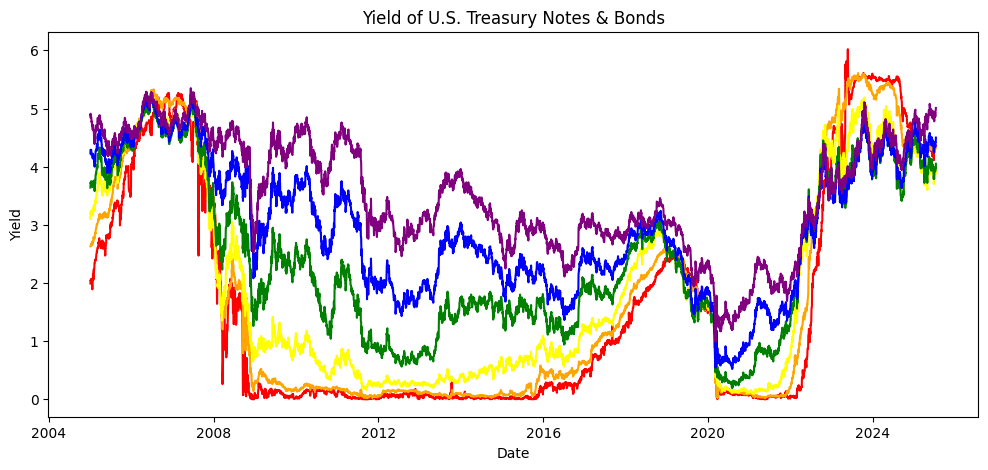

In [81]:
# Plot yields through time
plt.figure(figsize = (12,5))
plt.plot(df['1MO'], color='red')
plt.plot(df['6MO'], color='orange')
plt.plot(df['2YR'], color='yellow')
plt.plot(df['5YR'], color='green')
plt.plot(df['10YR'], color='blue')
plt.plot(df['30YR'], color='purple')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.title('Yield of U.S. Treasury Notes & Bonds')
plt.show()

In [ ]:
# Split into training and test data
train_portion = 0.9
n_train = int(len(df) * train_portion)
df_train = df.iloc[:n_train]
df_test = df.iloc[n_train:]

## PCA Analysis

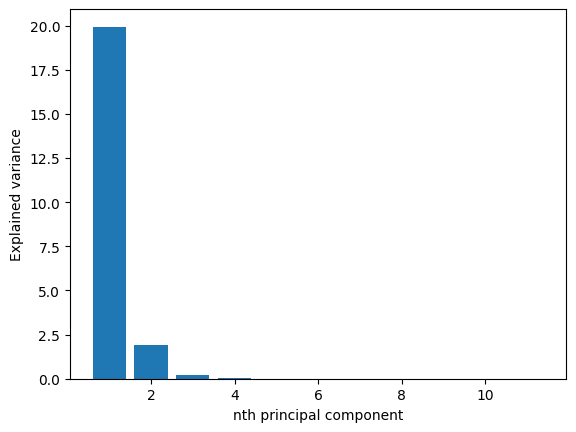

In [66]:
# Center the train data before PCA
yield_mean = df_train.mean()
df_train_c = df_train - yield_mean

# Examine the main contributing components
# Get all principal components of PCA
pca_all = PCA(n_components=df.shape[1])
pca_all.fit(df_train_c)
loadings = pca_all.components_

# Plot explained variance of each component
explained_var = pca_all.explained_variance_
plt.bar(np.arange(1,12),explained_var)
plt.xlabel('nth principal component')
plt.ylabel('Explained variance')
plt.show()


In [67]:
# Get the first three components
pca = PCA(n_components=3)
pca.fit(df_train_c)
loadings = pca.components_

# Adjust direction of components to correctly infer the dynamics
loadings[1] *= -1

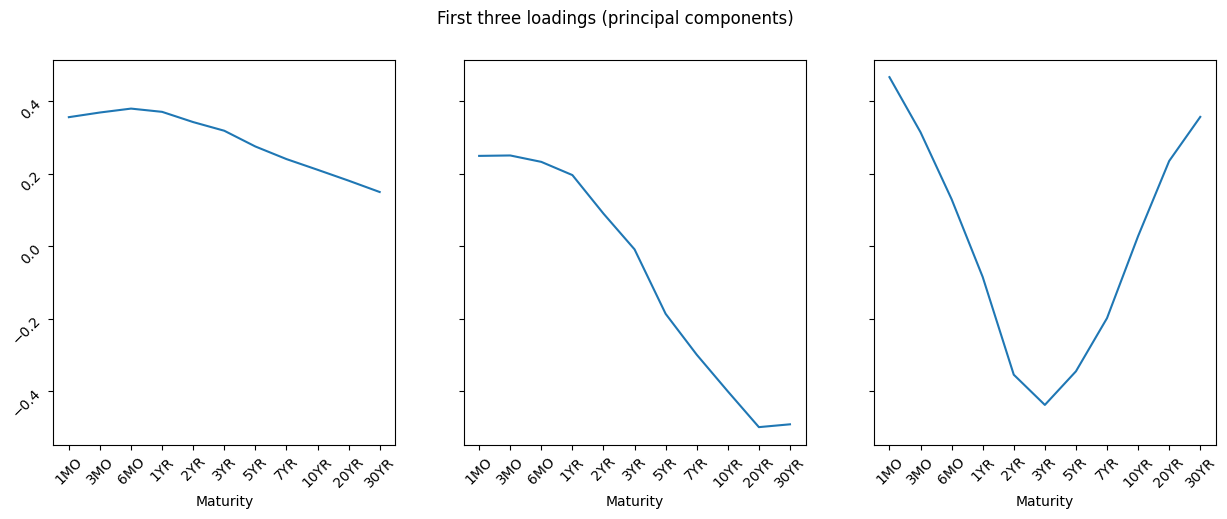

In [68]:
# Plot the first three components
fig, ax = plt.subplots(1,3,figsize=(15,5), sharey=True)
ax[0].plot(loadings[0])
ax[0].set_xticks(np.arange(0,11), name)
ax[0].tick_params(labelrotation=45)
ax[0].set_xlabel('Maturity')
ax[1].plot(loadings[1])
ax[1].set_xticks(np.arange(0,11), name)
ax[1].tick_params(labelrotation=45)
ax[1].set_xlabel('Maturity')
ax[2].plot(loadings[2])
ax[2].set_xticks(np.arange(0,11), name)
ax[2].tick_params(labelrotation=45)
ax[2].set_xlabel('Maturity')
fig.suptitle('First three loadings (principal components)')
plt.show()

In [69]:
# Represent the original training data in a basis of the first three loadings
scores = df_train_c.to_numpy() @ loadings.T
scores

array([[ 4.00649276, -1.67774709, -0.27278562],
       [ 4.18468394, -1.77323334, -0.32700963],
       [ 4.18769346, -1.74421249, -0.36521333],
       ...,
       [ 8.76513299,  2.23017421,  0.66828601],
       [ 8.75294524,  2.26478709,  0.65891899],
       [ 8.9128077 ,  2.14512073,  0.59844624]], shape=(4623, 3))

## Forcasting using VAR (Vector Autoregression)

In [70]:
# Use VAR (Vector Autoregression) to model the dynamics of score
var_model = VAR(scores)
maxlag = 15
var_res = var_model.fit(maxlags=maxlag, ic='aic')      # Set max la = 15
var_res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 16, Jul, 2025
Time:                     21:34:23
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -15.0816
Nobs:                     4608.00    HQIC:                  -15.2065
Log likelihood:           15714.7    FPE:                2.32502e-07
AIC:                     -15.2744    Det(Omega_mle):     2.25676e-07
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.000860         0.001804            0.477           0.633
L1.y1          1.091878         0.017861           61.132           0.000
L1.y2          0.131842         0.025186            5.235           0.000
L1.y3          0.

In [72]:
# Forecast score using the fitted VAR model
score_fore = var_res.forecast(scores[-maxlag:], steps=len(df_test))

# Transform the forecasted scores back to yields
yield_fore = yield_mean + pd.DataFrame(score_fore @ loadings, columns=df.columns)
yield_fore

,1MO,3MO,6MO,1YR,2YR,3YR,5YR,7YR,10YR,20YR,30YR
0,5.252056,5.355008,5.418940,5.208791,4.720559,4.412950,4.052816,3.897155,3.835274,3.971564,3.909136
1,5.255909,5.358494,5.421901,5.210989,4.721540,4.413292,4.052701,3.896967,3.835298,3.971752,3.909536
2,5.246133,5.348231,5.411374,5.200793,4.712833,4.406143,4.048696,3.895223,3.835676,3.974210,3.912719
3,5.242284,5.344999,5.409000,5.199530,4.713309,4.407522,4.050674,3.897220,3.837287,3.975502,3.913506
4,5.249839,5.351222,5.413407,5.201621,4.711864,4.404314,4.046488,3.893193,3.834262,3.973332,3.912430
...,...,...,...,...,...,...,...,...,...,...,...
509,3.905196,4.003143,4.096482,3.996857,3.764170,3.653433,3.599770,3.639761,3.729682,4.020327,4.008287
510,3.903045,4.000965,4.094319,3.994837,3.762493,3.652023,3.598787,3.639062,3.729208,4.020082,4.008152
511,3.900895,3.998788,4.092158,3.992818,3.760816,3.650613,3.597804,3.638363,3.728733,4.019835,4.008016
512,3.898747,3.996612,4.089999,3.990801,3.759140,3.649204,3.596820,3.637663,3.728257,4.019588,4.007879


In [73]:
# Compare the forecasted yields with the test data

# Mean square error
MSE = np.mean(np.sum((yield_fore.to_numpy() - df_test.to_numpy())**2, axis=1))
MSE

np.float64(2.559406816344832)